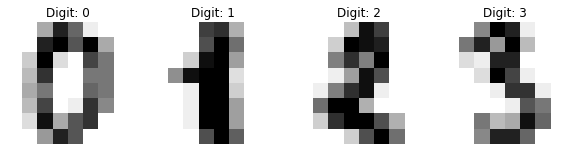

Epoch 0:
Train Score = 0.5463994060876021
Test  Score = 0.5288888888888889
Epoch 1:
Train Score = 0.6481069042316259
Test  Score = 0.6355555555555555
Epoch 2:
Train Score = 0.7446176688938382
Test  Score = 0.76
Epoch 3:
Train Score = 0.749072011878248
Test  Score = 0.7244444444444444
Epoch 4:
Train Score = 0.8262806236080178
Test  Score = 0.8066666666666666
Epoch 5:
Train Score = 0.8596881959910914
Test  Score = 0.84
Epoch 6:
Train Score = 0.8893838158871566
Test  Score = 0.8822222222222222
Epoch 7:
Train Score = 0.9049740163325909
Test  Score = 0.9111111111111111
Epoch 8:
Train Score = 0.9287305122494433
Test  Score = 0.9066666666666666
Epoch 9:
Train Score = 0.9317000742390498
Test  Score = 0.9244444444444444
Epoch 10:
Train Score = 0.9398663697104677
Test  Score = 0.9222222222222223
Epoch 11:
Train Score = 0.9443207126948775
Test  Score = 0.9244444444444444
Epoch 12:
Train Score = 0.9450631031922792
Test  Score = 0.9133333333333333
Epoch 13:
Train Score = 0.9480326651818857
Test  Sc

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from numpy.random import uniform
from sklearn import datasets
import seaborn as sns
import random

def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def relu(z):
    """Rectified linear unit function"""
    return max(0, z)

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

def vectorized_result(i):
    """
    Return 10 length unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    from 0 -> 9 into a corresponding desired output from the neural
    network.
    """
    out = np.zeros((10, 1))
    out[i] = 1
    return out

class SigmoidActivation:
    @staticmethod
    def activation(z):
        return sigmoid(z)
    @staticmethod
    def activation_prime(z):
        return sigmoid_prime(z)

class QuadraticCost:
    @staticmethod
    def C(a, y):
        return 0.5 * np.linalg.norm(a - y)**2
    @staticmethod
    def derivative(z, a, y):
        return (a - y) * sigmoid_prime(z)

class CrossEntropyCost:
    @staticmethod
    def C(a, y):
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
    @staticmethod
    def derivative(z, a, y):
        return a - y


class MLPClassifier:

    def __init__(self, hidden_layer_sizes,
                 mini_batch_size=10,
                 activation=SigmoidActivation,
                 cost=CrossEntropyCost,
                 learning_rate=2,
                 max_iter=100,
                 tol=1E-4,
                 n_iter_no_change=10):
        """
        Constructs attributes for neural network class.

        Parameters
        ----------
        hidden_layer_sizes : list[int]
            Sizes of hidden layers in the network. Does not include input or output layer sizes.
        mini_batch_size : int
            Size of mini-batch used to train the NN.
        activation : class
            Activation class to calculate activation and derivative of activation. Must have methods of
            activation(z) and activation_prime(z).
            SigmoidActivation is provided.
        cost : class
            Cost function class to calculate cost and derivative of cost. Must have methods of
            C(a, y) and derivative(z, a, y).
        learning_rate : float
            Learning rate used in training the neural network.
        max_iter : int
            Maximum number of epochs used to train the neural network.
        tol : float
            Tolerance of score change, used to calculate a minimum improvement of score for a training epoch to be
            considered improving.
        n_iter_no_change : int
            Number of consecutive iterations with no score improvement above tol until training is halted.
        """

        self.sizes = hidden_layer_sizes
        self.num_layers = len(self.sizes) + 2
        self.mini_batch_size = mini_batch_size
        self.activation = activation
        self.cost = cost
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.n_iter_no_change=n_iter_no_change

    def fit(self, X_train, y_train, X_test, y_test):
        """
        Trains the neural network with stochastic gradient descent.

        1. Flattens inputs into vectors.
        2. Initializes the weights and biases.
        3. Performs stochastic gradient descent
        """
        self.x_train = [x.flatten()[..., np.newaxis] for x in X_train]
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.x_test = [x.flatten()[..., np.newaxis] for x in X_test]

        # Initialize the weights and biases from standard normal distribution
        self.sizes = [self.x_train[0].shape[0]] + self.sizes + [self.y_train[0].shape[0]]
        self.biases = [np.random.standard_normal([y, 1]) for y in self.sizes[1:]]
        self.weights = [np.random.standard_normal([y, x])
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

        # Perform SGD
        self.stochastic_gradient_descent()

    def feedforward(self, a):
        """Returns the NN output, for input a."""
        for b, w in zip(self.biases, self.weights):
            a = self.activation.activation(np.dot(w, a) + b)
        return a

    def stochastic_gradient_descent(self):
        """
        Train the NN with mini-batch stochastic gradient descent
        """

        n = len(self.x_train)
        epoch = 0
        no_change_iter = 0
        scores = [0]
        score_change = 1
        while no_change_iter < self.n_iter_no_change and epoch < self.max_iter:
            # Zip x and y training sets into list of tuples for shuffling
            training_data = list(zip(self.x_train, self.y_train))
            random.shuffle(training_data)
            # Split into minibatches
            mini_batches = [training_data[k:k+self.mini_batch_size]
                            for k in range(0, n, self.mini_batch_size)]
            # Iterate through mini batches and train NN
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch)
            # Evaluate
            train_score = self.evaluate(self.x_train, self.y_train)
            score = self.score()

            # Report results
            print(f"Epoch {epoch}:")
            print(f"Train Score = {train_score}")
            print(f"Test  Score = {score}")

            score_change = score - scores[-1]
            scores.append(score)
            epoch += 1
            # If the NN did not improve, begin counting the number of iterations with no change
            if score_change < self.tol:
                no_change_iter += 1
            else:
                no_change_iter = 0

    def update_mini_batch(self, mini_batch):
        """
        Update the network's weights and biases by applying gradient
        descent using backpropagation to a single mini batch.

        mini_batch : list of tuples (x, y)
        eta : learning rate
        n : total size of training data set
        """
        # Initialize list of partial derivatives
        del_b = [np.zeros(b.shape) for b in self.biases]
        del_w = [np.zeros(w.shape) for w in self.weights]

        # Iterate through mini batch, get change in bias/weight partial derivative from backprop
        for x, y in mini_batch:
            delta_del_b, delta_del_w = self.backprop(x, y)
            del_b = [db + ddb for db, ddb in zip(del_b, delta_del_b)]
            del_w = [dw + ddw for dw, ddw in zip(del_w, delta_del_w)]

        eta = self.learning_rate
        self.weights = [w - (eta / len(mini_batch)) * dw
                        for w, dw in zip(self.weights, del_w)]
        self.biases = [b - (eta / len(mini_batch)) * db
                       for b, db in zip(self.biases, del_b)]

    def backprop(self, x, y):
        """
        Performs backpropagation for input x and output y.
        Return a tuple (del_b, del_w) representing the
        gradient for the cost function C_x.
        del_b & del_w are layer-by-layer lists of numpy arrays, similar
        to self.biases and self.weights.
        """
        del_b = [np.zeros(b.shape) for b in self.biases]
        del_w = [np.zeros(w.shape) for w in self.weights]

        # Feedforward Section
        activation = x
        activations = [x]  # List to store the activations
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)

        # Backward pass
        delta = self.cost.derivative(z, activation, y) * self.activation.activation_prime(zs[-1])
        del_b[-1] = delta
        del_w[-1] = np.dot(delta, activations[-2].transpose())

        for l in range(2, self.num_layers):
            z = zs[-l]
            activation_derivative = self.activation.activation_prime(z)

            delta = np.dot(self.weights[-l+1].transpose(), delta) * activation_derivative
            del_b[-l] = delta
            del_w[-l] = np.dot(delta, activations[-l-1].transpose())

        return del_b, del_w

    def evaluate(self, x, y):
        """
        Returns the fraction of correct outputs from the NN.
        """
        results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                   for x, y in zip(x, y)]
        return sum([int(x == y) for x, y in results]) / len(x)

    def score(self):
        """
        Returns the fraction of correct outputs from the NN.
        """
        results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                   for x, y in zip(self.x_test, self.y_test)]
        return sum([int(x == y) for x, y in results]) / len(self.x_test)


if __name__ == "__main__":
    # Load MNIST data, split into X,y train & test
    digits = datasets.load_digits()
    X = digits.images
    y = [vectorized_result(i) for i in digits.target]
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # View 4 digits
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
    for ax, image, label in zip(axes, digits.images, digits.target):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
        ax.set_title(f"Digit: {label}")
    plt.show()

    # Create & train model
    nn = MLPClassifier(hidden_layer_sizes=[50], learning_rate=1.2)
    nn.fit(X_train, y_train, X_test, y_test)
    accuracy = nn.score()
    print(f"Final Score: {accuracy}")


    #'''